1000 1000
1000 1000
First five samples of x : tensor([[ 0.7422,  0.2467],
        [-0.7340,  0.1687],
        [-0.8299,  0.2220],
        [-0.4291,  0.6722],
        [ 0.4456, -0.8949]])
First five samples of y : tensor([1., 1., 1., 1., 0.])
         X1        X2  label
0  0.742207  0.246686    1.0
1 -0.734032  0.168692    1.0
2 -0.829859  0.221959    1.0
3 -0.429136  0.672230    1.0
4  0.445602 -0.894936    0.0
5 -0.469885  0.708037    1.0
6 -0.016045  0.805623    1.0
7  0.759623  0.159526    1.0
8 -0.175692 -0.799837    1.0
9 -0.110616  1.042207    0.0
         X1        X2  label
0  0.742207  0.246686    1.0
1 -0.734032  0.168692    1.0
2 -0.829859  0.221959    1.0
3 -0.429136  0.672230    1.0
4  0.445602 -0.894936    0.0
5 -0.469885  0.708037    1.0
6 -0.016045  0.805623    1.0
7  0.759623  0.159526    1.0
8 -0.175692 -0.799837    1.0
9 -0.110616  1.042207    0.0
200 200 200 800
Model(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): BatchNor

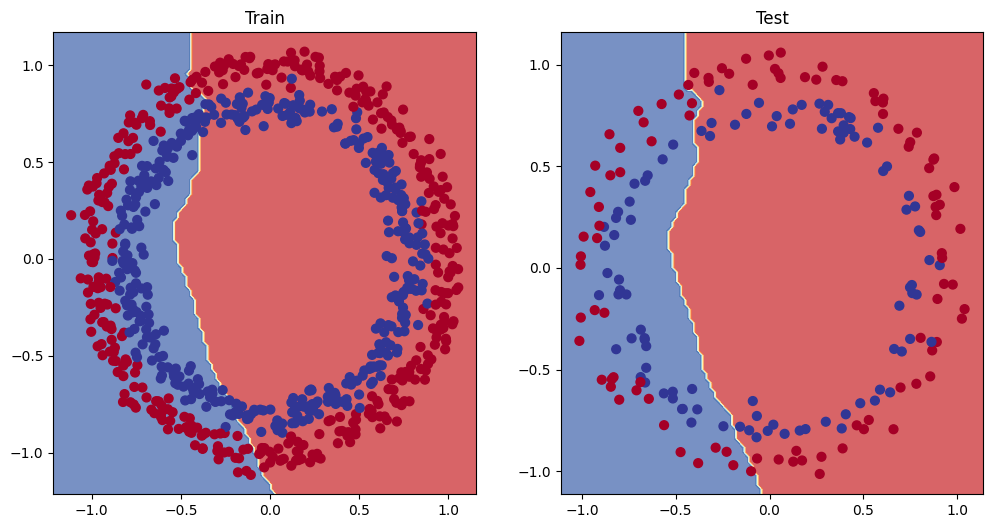

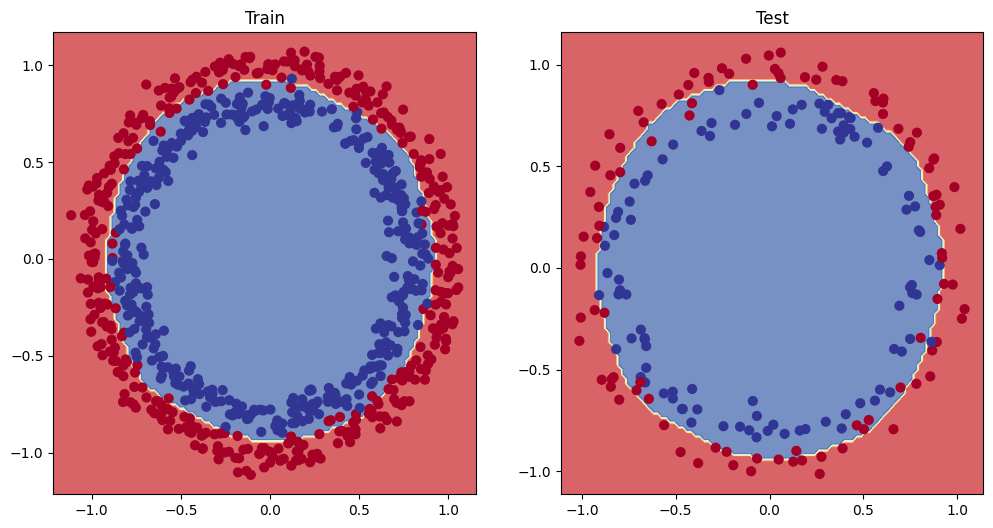

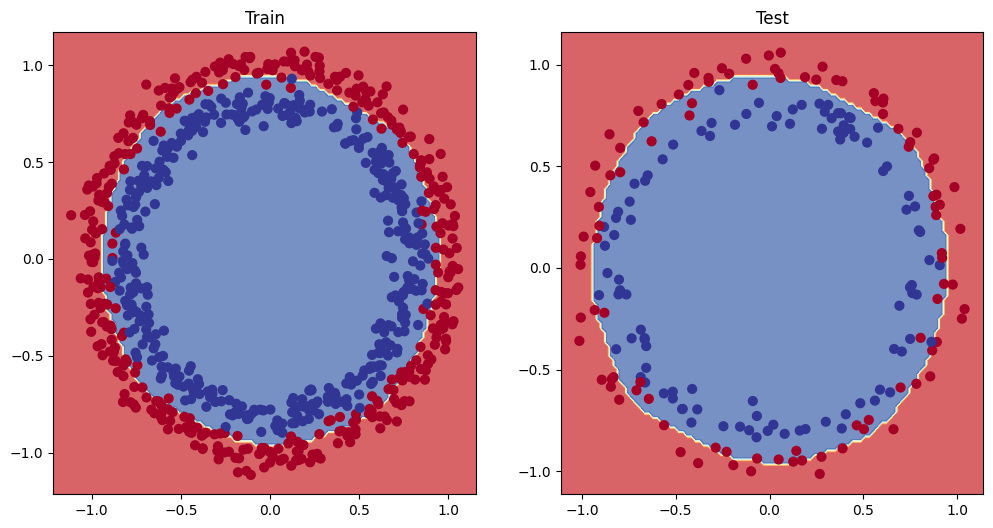

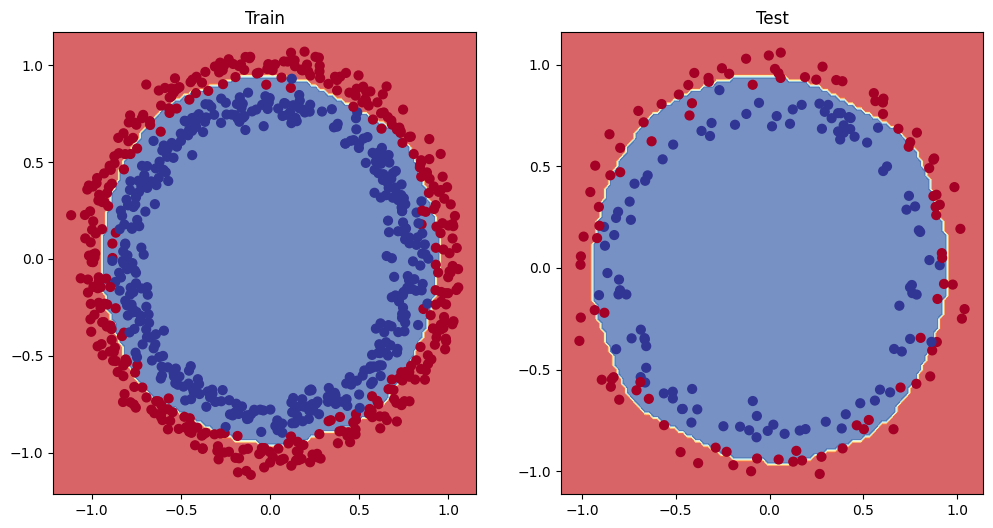

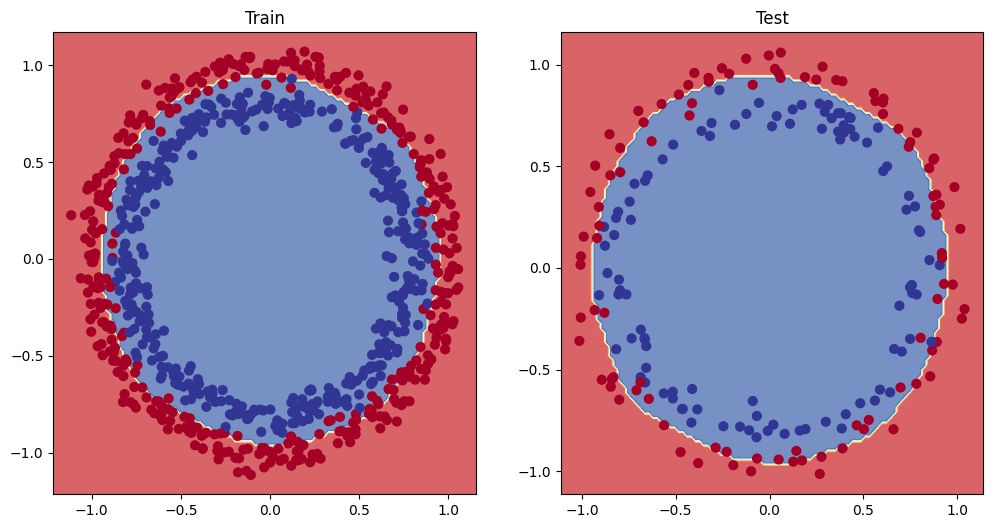

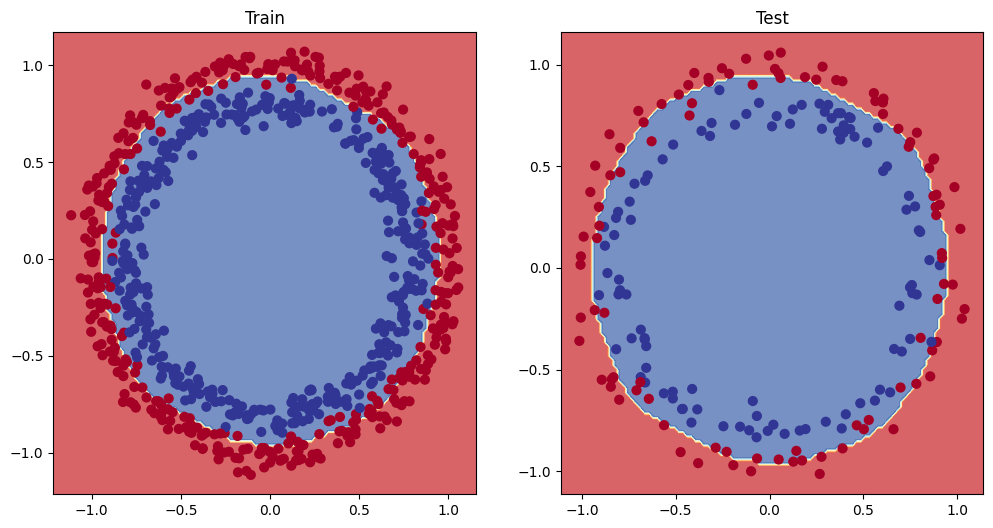

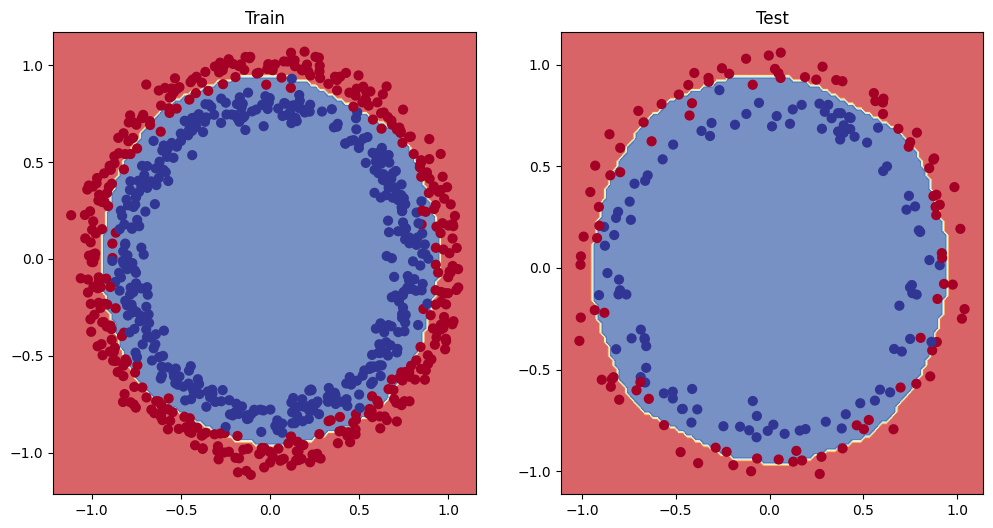

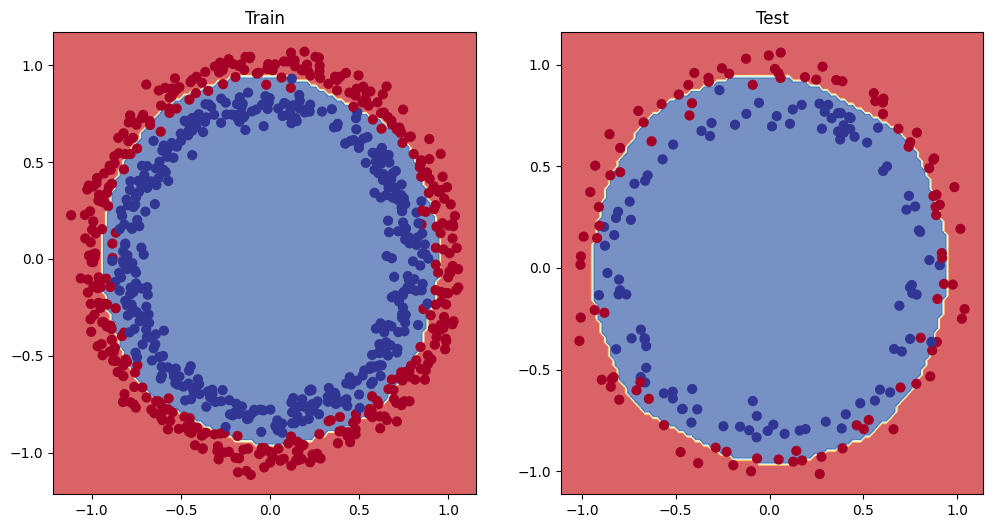

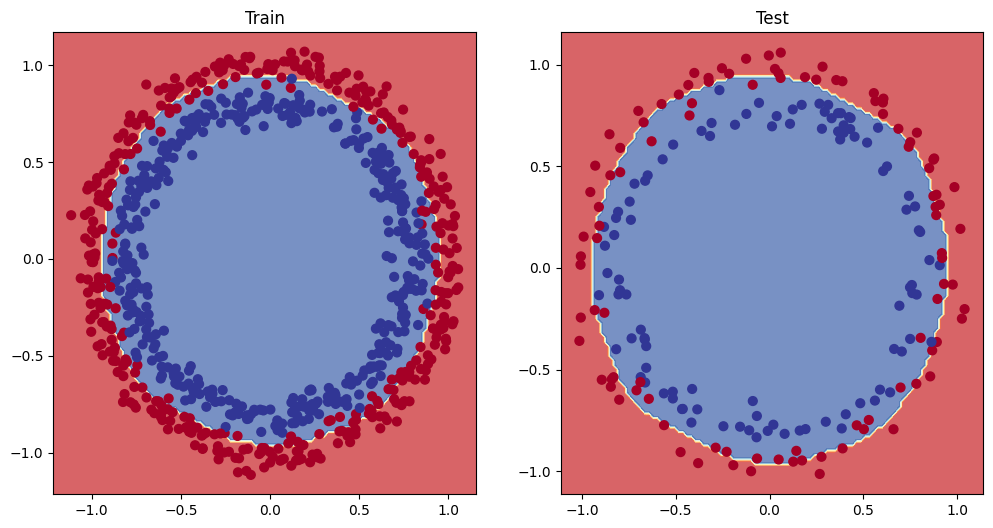

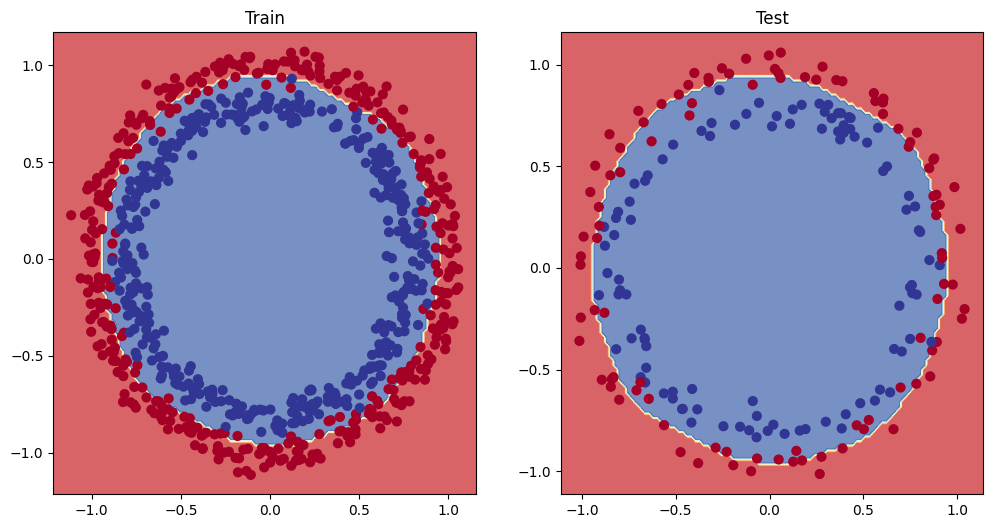

In [1]:
from sklearn.datasets import make_circles
from torch import nn
from torch.ao.nn.quantized.modules import Sigmoid
from torch.nn.qat.modules import Linear 
import torch as t
import pandas as pd

n_samples = 1000

x,y = make_circles(n_samples=n_samples , noise=0.05 , random_state=42)

x,y = t.from_numpy(x).type(t.float) , t.from_numpy(y).type(t.float)

print(len(x),len(y))

print(len(x) , len(y))
print(f"First five samples of x : {x[:5]}")
print(f"First five samples of y : {y[:5]}")



circle = pd.DataFrame({"X1":x[:,0], "X2":x[:,1], "label":y})

circle = pd.DataFrame({"X1":x[:,0], "X2":x[:,1], "label":y})
print(circle.head(10))

print(circle.head(10))



device = "cuda" if t.cuda.is_available() else 'cpu'

from sklearn.model_selection import train_test_split as tts
x_train , x_test , y_train, y_test = tts(x,y,test_size=0.2,random_state=42)

print(len(x_test),len(x_test),len(y_test),len(y_train))





ls_fun = nn.BCEWithLogitsLoss()

def acc_fun(y_true,y_pred):
    
    corr = t.eq(y_true,y_pred).sum().item()
    acc_c = (corr/len(y_true)) * 100
    
    return acc_c


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
                        nn.BatchNorm1d(64),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(in_features=64, out_features=64),
                        nn.BatchNorm1d(64),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(in_features=64, out_features=1),
           
        )
       
       
    def  forward(self,x:t.Tensor) :
        return self.seq(x)
        
model_v  = Model().to(device)
print(model_v)
print(model_v.state_dict())



optim = t.optim.SGD(model_v.parameters(), lr=0.1)
scheduler = t.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.1)
t.manual_seed(42)

# Move to device
x_test, x_train = x_test.to(device), x_train.to(device)
y_test, y_train = y_test.to(device), y_train.to(device)

epochs = 1000

for epoch in range(epochs):
    
    # Training mode
    model_v.train()
    
    # Forward pass
    y_logits = model_v(x_train).squeeze()
    y_preds = t.round(t.sigmoid(y_logits))
    
    # Compute loss and accuracy
    loss = ls_fun(y_logits, y_train)  # Compare logits with true labels
    acc = acc_fun(y_train, y_preds)
    
    # Optimizer
    optim.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Optimizer step
    optim.step()
    scheduler.step()
    
    # Evaluation mode
    model_v.eval()
    
    with t.no_grad():  # Disable gradient calculation for evaluation
        test_logits = model_v(x_test).squeeze()
        test_preds = t.round(t.sigmoid(test_logits))
        
        # Compute test loss and accuracy
        test_loss = ls_fun(test_logits, y_test)  # Compare logits with true labels
        test_acc = acc_fun(y_test, test_preds)
        
    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f} %| test_loss : {test_loss:.5f} | test_acc : {test_acc:.2f}")
        import requests
        from pathlib import Path 
        
        if Path('helper_function.py').is_file():
            print("helper_function.py file exists")
            
        else :
            print("Downloading helper_function.py file")
            request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
            
            with open('helper_function.py' , 'wb') as f:
                f.write(request.content)
        
        
        from helper_function import plot_loss_curves , plot_decision_boundary
        import matplotlib.pyplot as plt 
        
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.title("Train")
        plot_decision_boundary(model_v,x_train,y_train)
        
        plt.subplot(1,2,2)
        plt.title('Test')
        plot_decision_boundary(model_v,x_test,y_test)
